# Libraries

In [1]:
import tensorflow as tf
from google.colab import drive
import tensorflow.keras as keras
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2 

from functools import partial

from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import add
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

     |████████████████████████████████| 2.3MB 3.3MB/s 


# Download dataset

## Kaggle crediential

In [ ]:
!pip install kaggle

In [ ]:
from shutil import copyfile
import json

def get_kaggle_credential():
  src = '/content/drive/MyDrive/modelCode/kaggle.json'
  dst = '/content/kaggle.json'
  copyfile(src, dst)

  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)

  with open('/content/kaggle.json', 'r') as json_file:
    json_obj = json.load(json_file)

  result = json.dumps(json_obj).encode()
  with open(token_file, "wb") as f:
    f.write(result)
    os.chmod(token_file, 600)

get_kaggle_credential()

import kaggle

## Download celeb faces dataset


In [ ]:
dataset_name = '5-celebrity-faces-dataset'

In [ ]:
!kaggle datasets download dansbecker/5-celebrity-faces-dataset -p {'/content/'} --unzip

 99% 5.00M/5.03M [00:00<00:00, 20.4MB/s]
100% 5.03M/5.03M [00:00<00:00, 19.9MB/s]


In [ ]:
!unzip /content/face-images-20210420T141308Z-001.zip

Archive:  /content/face-images-20210420T141308Z-001.zip
  inflating: face-images/loc/20210420_210238.jpg  
  inflating: face-images/loc/20210420_210319.jpg  
  inflating: face-images/loc/20210420_210408.jpg  
  inflating: face-images/loc/20210420_210322.jpg  
  inflating: face-images/loc/20210420_210255.jpg  
  inflating: face-images/loc/20210420_210327.jpg  
  inflating: face-images/loc/20210420_210212.jpg  
  inflating: face-images/loc/20210420_210325.jpg  
  inflating: face-images/dat/20210420_210543.jpg  
  inflating: face-images/dat/20210420_210554.jpg  
  inflating: face-images/dat/20210420_210559.jpg  
  inflating: face-images/dat/20210420_210537.jpg  
  inflating: face-images/dat/20210420_210609.jpg  
  inflating: face-images/dat/20210420_210529.jpg  
  inflating: face-images/dat/20210420_210526.jpg  
  inflating: face-images/loc/20210420_210327(0).jpg  


# Implementation

## save data

In [ ]:
def extract_face_tf(im_path, im_size=[160, 160]):
  image = tf.io.read_file(im_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, im_size)

  image = image.numpy()
  detector = MTCNN()
  results = detector.detect_faces(image)
  
  a1, b1, width, height = results[0]['box']
  a1, b1 = abs(a1), abs(b1)
  a2, b2 = a1 + width, b1 + height
  
  im_face = image[b1:b2, a1:a2]
  im_face = tf.convert_to_tensor(im_face, dtype=tf.float32)
  im_face = tf.image.resize(im_face, im_size)
  return im_face


0.9999913


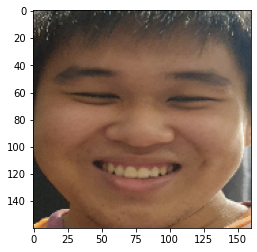

In [ ]:
protoPath = os.path.join('/content/face_anti_spoofing/face_detector', "deploy.prototxt")
modelPath = os.path.join('/content/face_anti_spoofing/face_detector',"res10_300x300_ssd_iter_140000.caffemodel")
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

def extract_face_better(im_path,model, im_size=(160, 160)):
    # load image from file
    image = cv2.imread(im_path)
    # convert to RGB, if needed
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    (h, w) = pixels.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(pixels, (300, 300)), 1.0,
		(300, 300), (104.0, 177.0, 123.0))
    model.setInput(blob)
    detections = model.forward()

    # Neu tim thay it nhat 1 khuon mat
    if len(detections) > 0:

      # Tim khuon  mat to nhat trong anh
      i = np.argmax(detections[0, 0, :, 2])
      confidence = detections[0, 0, i, 2]
      print(confidence)
      # Neu muc do nhan dien > threshold
      if confidence > 0.7:
        #Tach khuon mat va ghi ra file
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        face = pixels[startY:endY, startX:endX]
    
        # resize pixels to the model size
        image = cv2.resize(face, im_size)
        face_array = np.asarray(image)
        return face_array
    else:
      return 0
a = extract_face_better('/content/face-images/loc/20210420_210325.jpg', model=net)
plt.imshow(a)
plt.show()

In [ ]:
def extract_face(im_path, im_size=(160, 160)):
    # load image from file
    image = cv2.imread(im_path)
    print(image.shape)
    # convert to RGB, if needed
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = cv2.resize(face, im_size)
    face_array = np.asarray(image)
    return face_array
  
def load_face(directory):
  faces=[]
  for item in os.listdir(directory):
    im_path = os.path.join(directory, item)
    if '.jpg' not in im_path:
      continue
    print(im_path)
    face = extract_face(im_path)
    faces.append(face)
  return np.asarray(faces)

def load_dataset(directory):
  X = []
  y = []
  for item in os.listdir(directory):    
    subdir = os.path.join(directory, item)
    print(subdir)

    if not os.path.isdir(subdir):
      continue
    
    faces = load_face(subdir)
    print(faces.shape)
    labels = [item for i in range(len(faces))]

    X.extend(faces)
    y.extend(np.array(labels))
  return np.asarray(X), np.asarray(y)  

In [ ]:
train_path = '/content/face-images/'
#val_path = '/content/data/val'

In [ ]:
X_train, y_train = load_dataset(train_path)
#X_val, y_val = load_dataset(val_path)

np.savez_compressed('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/loc-dat.npz',
                    X_train,
                    y_train)
                    #X_val,
                    #y_val)


/content/face-images/dat
/content/face-images/dat/20210420_210559.jpg
(4032, 3024, 3)
/content/face-images/dat/20210420_210526.jpg
(4032, 3024, 3)
/content/face-images/dat/20210420_210609.jpg
(4032, 3024, 3)
/content/face-images/dat/20210420_210554.jpg
(4032, 3024, 3)
/content/face-images/dat/20210420_210529.jpg
(4032, 3024, 3)
/content/face-images/dat/20210420_210543.jpg
(4032, 3024, 3)
(6, 160, 160, 3)
/content/face-images/loc
/content/face-images/loc/20210420_210327.jpg
(4032, 3024, 3)
/content/face-images/loc/20210420_210238.jpg
(3264, 2448, 3)
/content/face-images/loc/20210420_210212.jpg
(3264, 2448, 3)
/content/face-images/loc/20210420_210325.jpg
(4032, 3024, 3)
/content/face-images/loc/20210420_210327(0).jpg
(4032, 3024, 3)
/content/face-images/loc/20210420_210408.jpg
(3264, 2448, 3)
/content/face-images/loc/20210420_210319.jpg
(4032, 3024, 3)
/content/face-images/loc/20210420_210322.jpg
(4032, 3024, 3)
/content/face-images/loc/20210420_210255.jpg
(3264, 2448, 3)
(9, 160, 160, 3

In [ ]:
X_train.shape, y_train.shape

((15, 160, 160, 3), (15,))

IndexError: ignored

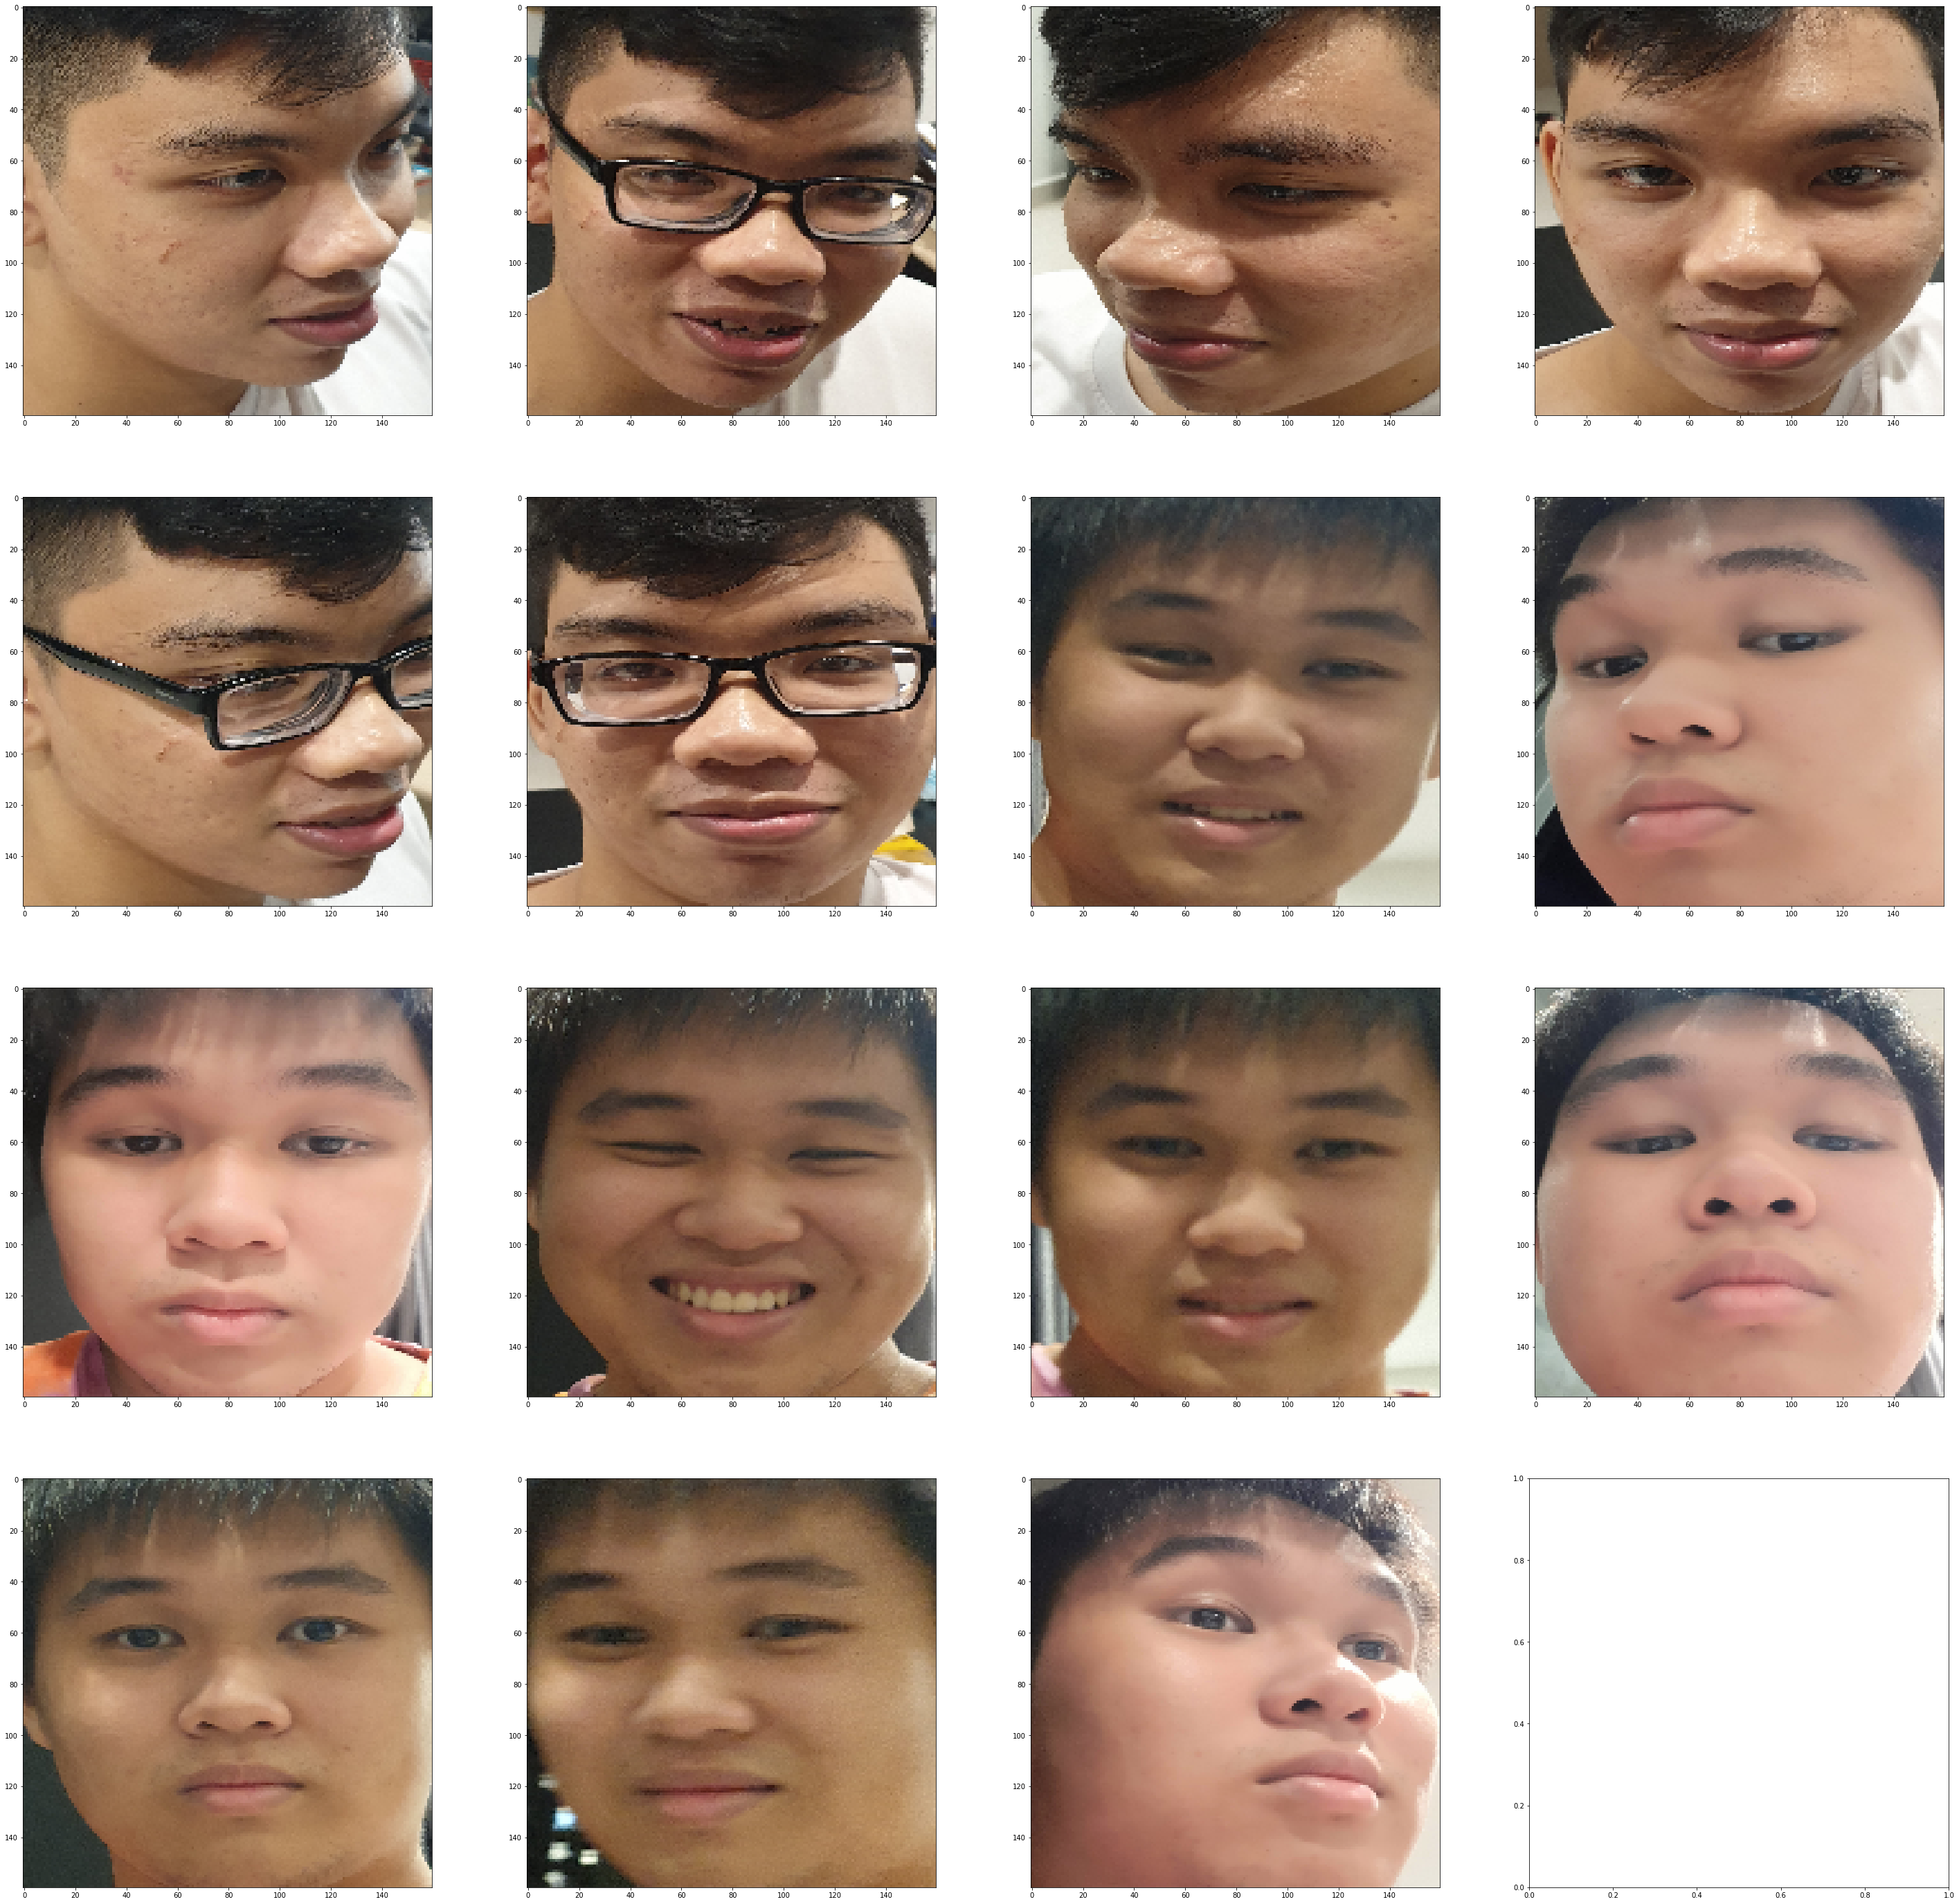

In [ ]:
fig = plt.figure(figsize=(50,50))
cols = 4
rows = 4
for i in range(1,cols*rows+ 1):
  plt.subplot(rows, cols, i)
  plt.imshow(X_train[i-1])
plt.show()

## Training

### Load model, data

In [ ]:
#Load pretrain facenet
facenet = keras.models.load_model('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/model/facenet_keras.h5')
facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [ ]:
#Load data for training
data = np.load('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/celebrity-faces-dataset.npz', allow_pickle=True)
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [ ]:
y_train

array(['dat', 'dat', 'dat', 'dat', 'dat', 'dat', 'loc', 'loc', 'loc',
       'loc', 'loc', 'loc', 'loc', 'loc', 'loc'], dtype='<U3')

### Normalization

In [ ]:
#Turn labels to integer
from sklearn.preprocessing import LabelEncoder

out_encoder = LabelEncoder()
out_encoder.fit(y_train)
trainy = out_encoder.transform(y_train)
#valy = out_encoder.transform(y_val)

In [ ]:
#Normalize data
t1, t2, t3, t4 = X_train.shape

meanTrain, stdTrain = X_train.mean(axis=(1,2,3)), X_train.std(axis=(1,2,3))
X_train = (X_train - np.reshape(meanTrain, (t1,1,1,1))) / np.reshape(stdTrain, (t1,1,1,1))

#v1, v2, v3, v4 = X_val.shape

#meanVal, stdVal = X_val.mean(axis=(1,2,3)), X_val.std(axis=(1,2,3))
#X_val = (X_val - np.reshape(meanVal, (v1,1,1,1))) / np.reshape(stdVal, (v1,1,1,1))

In [ ]:
#get embedding from facenet
trainX = facenet.predict(X_train)
#valX = facenet.predict(X_val)

trainX, trainy

(array([[ 1.0120763 ,  0.4986659 , -0.9618441 , ..., -2.2863517 ,
          0.8540346 , -1.1104149 ],
        [ 0.8323026 , -0.59809065, -1.4888417 , ..., -1.0901984 ,
          0.6311999 , -0.8161533 ],
        [ 0.6119708 ,  0.97724164, -0.47957763, ..., -1.9238598 ,
          0.4336126 , -0.9709751 ],
        ...,
        [ 0.6464268 , -0.7979187 , -0.80421793, ..., -1.4947851 ,
         -0.3141286 , -0.79825926],
        [ 0.4999754 , -0.86931133, -1.1566069 , ..., -1.5356249 ,
         -0.25826174, -0.8014723 ],
        [ 0.4133138 , -0.52476335, -0.16084182, ..., -1.9333105 ,
          0.1919776 , -1.2950088 ]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [ ]:
#shuffle training and validation set
def shuffledata(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a, b
trainX, trainy = shuffledata(trainX, trainy)
#valX, valy = shuffledata(valX, valy)

### Logistic Regression

In [ ]:
#Logistic Regression implementation
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C=80, solver='liblinear', penalty="l1",max_iter=1000)
log.fit(trainX, trainy)

print(log.score(trainX, trainy))
#print(log.score(valX, valy))

1.0


In [ ]:
#Save weight
log_name = 'logReg-locdat.sav'
pickle.dump(log, open(os.path.join('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline',log_name), 'wb'))

### SVM (optional)

In [ ]:
#SVM implementation (optional)
from sklearn.svm import SVC

SVM = SVC(C=100, kernel='linear', probability=True)
SVM.fit(trainX, trainy)

print(SVM.score(trainX, trainy))
print(SVM.score(valX, valy))

1.0
1.0


In [ ]:
#Save weight
svm_name = 'SVM-faceNet.sav'
pickle.dump(svm_name, open(os.path.join('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline',svm_name), 'wb'))

# Predict

In [ ]:
facenet_path = '/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/model/facenet_keras.h5'
log_path = '/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/logReg-faceNet.sav'

classes = ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [ ]:
#Load facenet
facenet = keras.models.load_model(facenet_path)
#Testing
x = np.zeros((160,160,3))
x = np.expand_dims(x, axis=0)

facenet.predict(x)

array([[-0.16026776, -0.43058437, -0.08495476, -0.45368713,  0.37071344,
         0.11544002, -0.038153  , -0.19679438, -0.03364314,  0.19351555,
         0.23007986, -0.299461  ,  0.1485142 , -0.31008583, -0.09590912,
         0.44437397,  0.3249636 , -0.33461165,  0.26422453, -0.5302316 ,
         0.18365473,  0.15576924, -0.16831654, -0.01893927,  0.2346716 ,
        -0.0929326 ,  0.49017146,  0.44747013, -0.12255533, -0.02273702,
        -0.23011252,  0.39446712,  0.01850768,  0.04234678,  0.509818  ,
        -0.44884035,  0.17330462,  0.11631432,  0.48783356,  0.10806295,
         0.23612002, -0.00526083, -0.09733835, -0.17481863, -0.43994656,
        -0.5388966 ,  0.02620834, -0.20854138,  0.53232837,  0.26953644,
        -0.4968047 ,  0.30348277,  0.21464375, -0.4289878 ,  0.11885324,
         0.12331288,  0.5294925 ,  0.0536785 , -0.33229357, -0.9041449 ,
        -0.44209343, -0.3582161 , -0.05992291,  0.70864886, -0.32271165,
         0.4846825 ,  0.30310625,  0.06076863,  0.2

In [ ]:
#Load logistic regression (SVM)
log = pickle.load(open(log_path, 'rb'))
#Testing
t = np.ones((1, 128))

log.predict(t)

array([4])

In [ ]:
class Baseline():
  def __init__(self, detector, predictor,fake_detector , class_map):
    self.detector = detector
    self.predictor = predictor
    self.class_map = class_map
    self.mtcnn_detector = MTCNN()
    self.fake_detector = fake_detector
  def extract(self, im, im_size=(160,160)):
    pixels = np.asarray(im)
    results = self.mtcnn_detector.detect_faces(pixels)

    x1, y1, width, height = results[0]['box']

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    face = pixels[y1:y2, x1:x2]
    image = cv2.resize(face, im_size)
    face_array = np.asarray(image)
    return face_array

  def normalize_facenet(self, im):
    mean, std = im.mean(axis=(1,2,3)), im.std(axis=(1,2,3))
    if np.all(std==0):
      std = np.ones(std.shape)

    im = (im - np.reshape(mean, (1,1,1,1))) / np.reshape(std, (1,1,1,1))

    return im

  def get_embedding(self, im):
    if im.ndim == 3:
      im = np.expand_dims(im, axis=0)
    elif im.ndim == 4:
      pass
    else:
      raise ValueError('Expected ndim = 4 or 3. Found ndim ='+ str(im.ndim))
    
    norm = self.normalize_facenet(im)
    embed = self.detector.predict(norm)
    return embed

  def get_prediction(self, embedding):
    return self.predictor.predict(embedding)

  def get_mapping(self, pred):
    return self.class_map[pred[0]]

  def get_fake_prediction(self, im):
    if im.ndim == 3:
      im = np.expand_dims(im, axis=0)
    elif im.ndim >4 or im.ndim <3:
      raise ValueError('Expected ndim = 4 or 3. Found ndim ='+ str(image.ndim))
    pred = self.fake_detector.predict(im)
    if pred[0] > 0.5:
      return 'real'
    else:
      return 'fake'
      
  def predict(self, image):
    if type(image) != np.ndarray:
      raise ValueError('Not a numpy array')
    if image.ndim <3 or image.ndim>4:
      raise ValueError('Expected ndim = 4 or 3. Found ndim ='+ str(image.ndim))

    ex = self.extract(image)
    em = self.get_embedding(ex)

    pred = self.get_prediction(em)
    pred = self.get_mapping(pred)
    return ex, pred

In [ ]:
#Testing 
predictor = Baseline(facenet, log, ['Dat', 'Loc'])
test = cv2.imread('/content/SE150150-NguyenTaiLoc.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = predictor.predict(test)
test 

'Loc'

# Liveness Detector

## Eye blink

In [ ]:
x, y = load_dataset('/content/data')
x.shape, y.shape
np.savez_compressed('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/real-fake.npz',
                    x,
                    y)

/content/data/fake
/content/data/fake/0158.jpg
(852, 480, 3)
/content/data/fake/0267.jpg
(852, 480, 3)
/content/data/fake/0044.jpg
(852, 480, 3)
/content/data/fake/0209.jpg
(852, 480, 3)
/content/data/fake/0183.jpg
(852, 480, 3)
/content/data/fake/0025.jpg
(852, 480, 3)
/content/data/fake/0050.jpg
(852, 480, 3)
/content/data/fake/0248.jpg
(852, 480, 3)
/content/data/fake/0086.jpg
(852, 480, 3)
/content/data/fake/0155.jpg
(852, 480, 3)
/content/data/fake/0283.jpg
(852, 480, 3)
/content/data/fake/0078.jpg
(852, 480, 3)
/content/data/fake/0168.jpg
(852, 480, 3)
/content/data/fake/0090.jpg
(852, 480, 3)
/content/data/fake/0279.jpg
(852, 480, 3)
/content/data/fake/0109.jpg
(852, 480, 3)
/content/data/fake/0053.jpg
(852, 480, 3)
/content/data/fake/0162.jpg
(852, 480, 3)
/content/data/fake/0119.jpg
(852, 480, 3)
/content/data/fake/0072.jpg
(852, 480, 3)
/content/data/fake/0223.jpg
(852, 480, 3)
/content/data/fake/0227.jpg
(852, 480, 3)
/content/data/fake/0094.jpg
(852, 480, 3)
/content/data/f

((515, 160, 160, 3), (515,))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)

(trainX, testX, trainY, testY) = train_test_split(x, y,
	test_size=0.2)

aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [ ]:

model = keras.models.Sequential()
model.add(Input(shape=(160,160,3)))

model.add(Conv2D(8, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6237 (Conv2D)         (None, 160, 160, 8)       224       
_________________________________________________________________
activation_70 (Activation)   (None, 160, 160, 8)       0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 160, 160, 8)       32        
_________________________________________________________________
conv2d_6238 (Conv2D)         (None, 160, 160, 8)       584       
_________________________________________________________________
activation_71 (Activation)   (None, 160, 160, 8)       0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 160, 160, 8)       32        
_________________________________________________________________
max_pooling2d_3118 (MaxPooli (None, 80, 80, 8)        

In [ ]:
opt = keras.optimizers.Adam(lr=1e-4, decay=1e-4 / 50)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
hist = model.fit(aug.flow(trainX, trainY, batch_size=8),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // 8,
	epochs=50)

Epoch 1/50
51/51 [==============================] - 17s 298ms/step - loss: 0.9130 - accuracy: 0.5659 - val_loss: 0.7339 - val_accuracy: 0.3786
Epoch 2/50
51/51 [==============================] - 15s 294ms/step - loss: 0.4968 - accuracy: 0.7798 - val_loss: 0.7845 - val_accuracy: 0.3786
Epoch 3/50
51/51 [==============================] - 15s 294ms/step - loss: 0.3212 - accuracy: 0.8480 - val_loss: 0.6841 - val_accuracy: 0.3786
Epoch 4/50
51/51 [==============================] - 15s 293ms/step - loss: 0.2220 - accuracy: 0.9254 - val_loss: 0.4405 - val_accuracy: 0.8544
Epoch 5/50
51/51 [==============================] - 15s 294ms/step - loss: 0.1837 - accuracy: 0.9337 - val_loss: 0.3090 - val_accuracy: 0.9903
Epoch 6/50
51/51 [==============================] - 15s 295ms/step - loss: 0.2175 - accuracy: 0.9234 - val_loss: 0.1989 - val_accuracy: 1.0000
Epoch 7/50
51/51 [==============================] - 15s 294ms/step - loss: 0.1664 - accuracy: 0.9291 - val_loss: 0.0907 - val_accuracy: 1.0000

In [ ]:
model.save('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/fak-real.h5')

In [ ]:
test = extract_face('/content/;pc.jpg')
test = np.expand_dims(test,axis=0)
model.predict(test)
#fake=0, real=1

(960, 720, 3)


array([[0.9998474]], dtype=float32)

In [ ]:
import dlib
from keras.models import load_model
import pickle

facenet_path = '/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/model/facenet_keras.h5'
log_path = '/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/logReg-locdat.sav'
fakereal_path = '/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/fak-real.h5'

classes = ['dat', 'loc']

In [ ]:
#Load facenet
facenet = load_model(facenet_path)
#Testing
x = np.zeros((160,160,3))
x = np.expand_dims(x, axis=0)

facenet.predict(x)

array([[-0.16026776, -0.43058437, -0.08495476, -0.45368713,  0.37071344,
         0.11544002, -0.038153  , -0.19679438, -0.03364314,  0.19351555,
         0.23007986, -0.299461  ,  0.1485142 , -0.31008583, -0.09590912,
         0.44437397,  0.3249636 , -0.33461165,  0.26422453, -0.5302316 ,
         0.18365473,  0.15576924, -0.16831654, -0.01893927,  0.2346716 ,
        -0.0929326 ,  0.49017146,  0.44747013, -0.12255533, -0.02273702,
        -0.23011252,  0.39446712,  0.01850768,  0.04234678,  0.509818  ,
        -0.44884035,  0.17330462,  0.11631432,  0.48783356,  0.10806295,
         0.23612002, -0.00526083, -0.09733835, -0.17481863, -0.43994656,
        -0.5388966 ,  0.02620834, -0.20854138,  0.53232837,  0.26953644,
        -0.4968047 ,  0.30348277,  0.21464375, -0.4289878 ,  0.11885324,
         0.12331288,  0.5294925 ,  0.0536785 , -0.33229357, -0.9041449 ,
        -0.44209343, -0.3582161 , -0.05992291,  0.70864886, -0.32271165,
         0.4846825 ,  0.30310625,  0.06076863,  0.2

In [ ]:
#Load logistic regression (SVM)
log = pickle.load(open(log_path, 'rb'))
#Testing
t = np.ones((1, 128))

log.predict(t)

array([4])

In [ ]:
fake_detector = load_model(fakereal_path)


In [ ]:
class Baseline():
  def __init__(self, detector, predictor,fake_detector , class_map):
    self.detector = detector
    self.predictor = predictor
    self.class_map = class_map
    self.mtcnn_detector = MTCNN()
    self.fake_detector = fake_detector
  def extract(self, im, im_size=(160,160)):
    pixels = np.asarray(im)
    results = self.mtcnn_detector.detect_faces(pixels)
    
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    for rets in results:

      x1, y1, width, height = rets['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height

      xmin.append(x1)
      ymin.append(y1)
      xmax.append(x2)
      ymax.append(y2)

    faces = []
    for i in range(len(results)):

      face = pixels[y1:y2, x1:x2]
      image = cv2.resize(face, im_size)
      face_array = np.asarray(image)
      faces.append(face_array)
    return faces

  def normalize_facenet(self, im):
    mean, std = im.mean(axis=(1,2,3)), im.std(axis=(1,2,3))
    if np.all(std==0):
      std = np.ones(std.shape)

    im = (im - np.reshape(mean, (im.shape[0], 1, 1, 1))) / np.reshape(std, (im.shape[0] , 1, 1, 1))

    return im

  def get_embedding(self, faces):
    faces = np.asarray(faces)
    
    if faces.ndim == 3:
      faces = np.expand_dims(faces, axis=0)
    elif faces.ndim >4 or faces.ndim <3:
      raise ValueError('Expected ndim = 4 or 3. Found ndim ='+ str(faces.ndim))
    
    norm = self.normalize_facenet(faces)
    embeddings = self.detector.predict(norm)
    return embeddings

  def get_prediction(self, embedding):
    return self.predictor.predict(embedding)

  def get_mapping(self, pred):
    return [self.class_map[i] for i in pred.tolist()]

  def get_fake_prediction(self, faces):
    faces = np.asarray(faces)
    if faces.ndim == 3:
      faces = np.expand_dims(faces, axis=0)
    elif faces.ndim >4 or faces.ndim <3:
      raise ValueError('Expected ndim = 4 or 3. Found ndim ='+ str(faces.ndim))

    pred = self.fake_detector.predict(faces)
    result = (pred > 0.5) * 1
    return result
      
  def predict_multiple(self, image):
    if type(image) != np.ndarray:
      raise ValueError('Not a numpy array')
    if image.ndim <3 or image.ndim>4:
      raise ValueError('Expected ndim = 4 or 3. Found ndim ='+ str(image.ndim))

    ex = self.extract(image)
    spoof = self.get_fake_prediction(ex)
    em = self.get_embedding(ex)

    pred = self.get_prediction(em)
    pred = self.get_mapping(pred)
    return ex, spoof, pred

In [ ]:
net = Baseline(facenet, log, fake_detector, classes)
# loading the liveness detecting module that was trained in the training python script
print("loading the liveness detector")

#determining the facial points that are plotted by dlib
FULL_POINTS = list(range(0, 68))  
FACE_POINTS = list(range(17, 68))  
   
JAWLINE_POINTS = list(range(0, 17))  
RIGHT_EYEBROW_POINTS = list(range(17, 22))  
LEFT_EYEBROW_POINTS = list(range(22, 27))  
NOSE_POINTS = list(range(27, 36))  
RIGHT_EYE_POINTS = list(range(36, 42))  
LEFT_EYE_POINTS = list(range(42, 48))  
MOUTH_OUTLINE_POINTS = list(range(48, 61))  
MOUTH_INNER_POINTS = list(range(61, 68))  
   
EYE_AR_THRESH = 0.30 
EYE_AR_CONSEC_FRAMES = 2  

#initializing the parameters
COUNTER_LEFT = 0  
TOTAL_LEFT = 0  
   
COUNTER_RIGHT = 0  
TOTAL_RIGHT = 0 
#defining a function for calculating ear and then comparing with the confidence parametrs

def eye_aspect_ratio(eye):
    
    A = dist.euclidean(eye[1], eye[5])  
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])  
    ear = (A + B) / (2.0 * C)  
    return ear 

#loading the predictor for predicting
detector = dlib.get_frontal_face_detector()  

#accessing the shape predictor
predictor = dlib.shape_predictor('/content/...')
#starting the stream
video_capture = cv2.VideoCapture(0)  
#looping over frames
while True:
    #checkpoint 1
    success, frame = video_capture.read()
    if success:
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
        rects = detector(gray, 0)
        frame = cv2.resize(frame, (512,512))
        for rect in rects:
            
            x = rect.left()  
            y = rect.top()  
            x1 = rect.right()  
            y1 = rect.bottom()
            landmarks = np.matrix([[p.x, p.y] for p in predictor(frame, rect).parts()])  
            left_eye = landmarks[LEFT_EYE_POINTS]  
            right_eye = landmarks[RIGHT_EYE_POINTS]

            left_eye_hull = cv2.convexHull(left_eye)  
            right_eye_hull = cv2.convexHull(right_eye)
              
            ear_left = eye_aspect_ratio(left_eye)  
            ear_right = eye_aspect_ratio(right_eye)
		
            #calculating blink wheneer the ear value drops down below the threshold
	
            if ear_left < EYE_AR_THRESH:
                
                COUNTER_LEFT += 1
            
            else:
                
                
                if COUNTER_LEFT >= EYE_AR_CONSEC_FRAMES:
                    
                    
                    TOTAL_LEFT += 1  
                    print("Left eye winked") 
                
                    COUNTER_LEFT = 0
            if ear_right < EYE_AR_THRESH:  
                
                
                COUNTER_RIGHT += 1  

            else:
                
                if COUNTER_RIGHT >= EYE_AR_CONSEC_FRAMES: 
                    
                    
                    TOTAL_RIGHT += 1  
                    print("Right eye winked")  
                    COUNTER_RIGHT = 0


            x = TOTAL_LEFT + TOTAL_RIGHT

    (h, w) = frame.shape[:2]
    image, spoof, pred = net.predict(frame)

    cv2.putText(frame, label, (startX, startY - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY),
    (0, 0, 255), 2)
 #showing the frames and waiting for the key to be pressed
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
cv2.destroyAllWindows()

In [11]:
import dlib
from imutils import face_utils
from scipy.spatial import distance as dist

RIGHT_EYE_POINTS = list(range(36, 42))  
LEFT_EYE_POINTS = list(range(42, 48))  

def eye_aspect_ratio(eye):
    
    A = dist.euclidean(eye[1], eye[5])  
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])  
    ear = (A + B) / (2.0 * C)  
    return ear

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/shape_predictor_68_face_landmarks_GTX.dat')

im = cv2.imread('/content/dcee839a5e14ac4af505.jpg')
im = cv2.resize(im, (500,500))
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 1)
# loop over the face detections
for (i, rect) in enumerate(rects):
  # determine the facial landmarks for the face region, then
  # convert the facial landmark (x, y)-coordinates to a NumPy
  # array of face
  shape = predictor(gray, rect)
  shape = face_utils.shape_to_np(shape)
  
  right_eye = shape[RIGHT_EYE_POINTS,:]
  left_eye = shape[LEFT_EYE_POINTS,:]

  ear_right = eye_aspect_ratio(right_eye)
  ear_left = eye_aspect_ratio(left_eye)

  print((ear_right+ear_left)/2.)
  

0.25844384854995606


In [ ]:
import dlib
from scipy.spatial import distance as dist

RIGHT_EYE_POINTS = list(range(36, 42))  
LEFT_EYE_POINTS = list(range(42, 48))  

RATIO_THRESH = 0.0017
EYE_AR_CONSEC_FRAMES = 2

# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0

FACIAL_LANDMARKS_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])


def eye_aspect_ratio(eye):
    
    A = dist.euclidean(eye[1], eye[5])  
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])  
    ear = (A + B) / (2.0 * C)  
    return ear 

def turn_aspect_ratio(x1,x2,x3):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(x1, x2)
	B = dist.euclidean(x2, x3)

	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	#C = dist.euclidean(eye[0], eye[3])

	# compute the eye aspect ratio
	# ear = (A + B) / (2.0 * C)

	# return the eye aspect ratio
	return A/B

def open_mouth_detection(x1,x2,x3,x4):
	A = dist.euclidean(x1, x2)
	B = dist.euclidean(x3, x4)

	return A/B

def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y

	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)

	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords


cap = cv2.VideoCapture(0)
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
event = "none"
event2 = "none"
detector = Baseline(facenet, log, fake_detector, classes)
predictor = dlib.shape_predictor('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/shape_predictor_68_face_landmarks_GTX.dat')
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    rame = cv2.resize(frame, (500, 500))
    # Our operations on the frame come here

    # detect faces in the image
    rects, spoof, pred = detector.predict(rame)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
      real = False
    	# determine the facial landmarks for the face region, then
    	# convert the facial landmark (x, y)-coordinates to a NumPy
    	# array of face
    	shape = predictor(gray, rect)
    	shape = shape_to_np(shape)

    	# 0.6 right and 1.6 left threshold
      #turn
    	ratio = turn_aspect_ratio(shape[1],shape[28],shape[17])
      #lips
    	lips_ratio = open_mouth_detection(shape[62],shape[66],shape[49],shape[59])

      #eye
      right_eye = shape[RIGHT_EYE_POINTS,:]
      left_eye = shape[LEFT_EYE_POINTS,:]
      ear_right = eye_aspect_ratio(right_eye)
      ear_left = eye_aspect_ratio(left_eye)
      ear = (ear_right+ear_left) / 2.0
  
		  (x, y, w, h) = rect_to_bb(rect)
      ear_ratio = ear /w

      if ear_ratio > RATIO_THRESH:
        COUNTER += 1

      else:
        if COUNTER >= EYE_AR_CONSEC_FRAMES:
          TOTAL +=1

        COUNTER = 0

      if COUNTER > 0:
        real = True

    	if lips_ratio>0.32:
    		event2="Mouth Open"
    
    	else:
    		event2="Mouth Close"

    	cv2.line(rame, tuple(shape[62]), tuple(shape[66]), (180, 42, 220), 2)
    	cv2.line(rame, tuple(shape[49]), tuple(shape[59]), (180, 42, 220), 2)
    	cv2.line(rame, tuple(shape[1]), tuple(shape[28]), (19, 199, 109), 2)
    	cv2.line(rame, tuple(shape[28]), tuple(shape[17]), (19, 199, 109), 2)
    	if ratio<0.6:
    		event="Right turn"
        real=True
    	elif ratio>1.6:
    		event="Left turn"
        real=True
    	else :
    		event="none"
        real=False

    	# convert dlib's rectangle to a OpenCV-style bounding box
    	# [i.e., (x, y, w, h)], then draw the face bounding box
      

      print(real)
      
    	#(x, y, w, h) = rect_to_bb(rect)
    	#cv2.rectangle(rame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    	# show the face number
    	#cv2.putText(rame, "Face #{}".format(i + 1), (x - 10, y - 10),
    	#	cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
      
    	#cv2.putText(rame, "Ratio: {}--{}".format(event,event2), (10, 30),
			#  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    	# loop over the (x, y)-coordinates for the facial landmarks
    	# and draw them on the image
    	for (x, y) in shape:
    		cv2.circle(rame, (x, y), 1, (0, 0, 255), -1)



    # Display the resulting frame
    cv2.imshow('frame',rame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
def scaling(x, scale):
    return x * scale


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                               scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)

    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "Block35", "Block17" or "Block8", '
                         'but got: ' + str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=name_fmt('Conv2d_1x1'))
    up = Lambda(scaling,
                output_shape=K.int_shape(up)[1:],
                arguments={'scale': scale})(up)
    x = add([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=None):
    inputs = Input(shape=input_shape)
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    x = conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

    # 5x Block35 (Inception-ResNet-A block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.17,
                                    block_type='Block35',
                                    block_idx=block_idx)

    # Mixed 6a (Reduction-A block):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 10x Block17 (Inception-ResNet-B block):
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x,
                                    scale=0.1,
                                    block_type='Block17',
                                    block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 5x Block8 (Inception-ResNet-C block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.2,
                                    block_type='Block8',
                                    block_idx=block_idx)
    x = _inception_resnet_block(x,
                                scale=1.,
                                activation=None,
                                block_type='Block8',
                                block_idx=6)

    # Classification block
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
    # Bottleneck
    x = Dense(classes, use_bias=False, name='Bottleneck')(x)
    bn_name = _generate_layer_name('BatchNorm', prefix='Bottleneck')
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)

    # Create model
    model = Model(inputs, x, name='inception_resnet_v1')
    if weights_path is not None:
        model.load_weights(weights_path)

    return model

In [ ]:
model = InceptionResNetV1()

In [ ]:
class FaceNet():
  def __init__(self,
                input_shape=(160, 160, 3),
                classes=128,
                dropout_keep_prob=0.8,
                weights_path=None):
    #super(FaceNet, self).__init__()
    self.input_shape = input_shape
    self.dropout_keep_prob = dropout_keep_prob
    self.classes = classes
    self.weights_path = weights_path
  
  def scaling(self, x, scale):
    return x * scale


  def conv2d_bn(self,
                x,
                filters,
                kernel_size,
                strides=1,
                padding='same',
                activation='relu',
                use_bias=False,
                name=None):
      x = Conv2D(filters,
                kernel_size,
                strides=strides,
                padding=padding,
                use_bias=use_bias,
                name=name)(x)
      if not use_bias:
          bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
          bn_name = self._generate_layer_name('BatchNorm', prefix=name)
          x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                                scale=False, name=bn_name)(x)
      if activation is not None:
          ac_name = self._generate_layer_name('Activation', prefix=name)
          x = Activation(activation, name=ac_name)(x)
      return x


  def _generate_layer_name(self, name, branch_idx=None, prefix=None):
      if prefix is None:
          return None
      if branch_idx is None:
          return '_'.join((prefix, name))
      return '_'.join((prefix, 'Branch', str(branch_idx), name))


  def _inception_resnet_block(self, x, scale, block_type, block_idx, activation='relu'):
      channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
      if block_idx is None:
          prefix = None
      else:
          prefix = '_'.join((block_type, str(block_idx)))
      name_fmt = partial(self._generate_layer_name, prefix=prefix)

      if block_type == 'Block35':
          branch_0 = self.conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
          branch_1 = self.conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
          branch_1 = self.conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
          branch_2 = self.conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
          branch_2 = self.conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
          branch_2 = self.conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
          branches = [branch_0, branch_1, branch_2]
      elif block_type == 'Block17':
          branch_0 = self.conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
          branch_1 = self.conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
          branch_1 = self.conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
          branch_1 = self.conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
          branches = [branch_0, branch_1]
      elif block_type == 'Block8':
          branch_0 = self.conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
          branch_1 = self.conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
          branch_1 = self.conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
          branch_1 = self.conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
          branches = [branch_0, branch_1]
      else:
          raise ValueError('Unknown Inception-ResNet block type. '
                          'Expects "Block35", "Block17" or "Block8", '
                          'but got: ' + str(block_type))

      mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
      up = self.conv2d_bn(mixed,
                    K.int_shape(x)[channel_axis],
                    1,
                    activation=None,
                    use_bias=True,
                    name=name_fmt('Conv2d_1x1'))
      up = Lambda(self.scaling,
                  output_shape=K.int_shape(up)[1:],
                  arguments={'scale': scale})(up)
      x = add([x, up])
      if activation is not None:
          x = Activation(activation, name=name_fmt('Activation'))(x)
      return x


  def InceptionResNetV1(self):
      inputs = Input(shape=self.input_shape)
      x = self.conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
      x = self.conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
      x = self.conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
      x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
      x = self.conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
      x = self.conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
      x = self.conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

      # 5x Block35 (Inception-ResNet-A block):
      for block_idx in range(1, 6):
          x = self._inception_resnet_block(x,
                                      scale=0.17,
                                      block_type='Block35',
                                      block_idx=block_idx)

      # Mixed 6a (Reduction-A block):
      channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
      name_fmt = partial(self._generate_layer_name, prefix='Mixed_6a')
      branch_0 = self.conv2d_bn(x,
                          384,
                          3,
                          strides=2,
                          padding='valid',
                          name=name_fmt('Conv2d_1a_3x3', 0))
      branch_1 = self.conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
      branch_1 = self.conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
      branch_1 = self.conv2d_bn(branch_1,
                          256,
                          3,
                          strides=2,
                          padding='valid',
                          name=name_fmt('Conv2d_1a_3x3', 1))
      branch_pool = MaxPooling2D(3,
                                strides=2,
                                padding='valid',
                                name=name_fmt('MaxPool_1a_3x3', 2))(x)
      branches = [branch_0, branch_1, branch_pool]
      x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

      # 10x Block17 (Inception-ResNet-B block):
      for block_idx in range(1, 11):
          x = self._inception_resnet_block(x,
                                      scale=0.1,
                                      block_type='Block17',
                                      block_idx=block_idx)

      # Mixed 7a (Reduction-B block): 8 x 8 x 2080
      name_fmt = partial(self._generate_layer_name, prefix='Mixed_7a')
      branch_0 = self.conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
      branch_0 = self.conv2d_bn(branch_0,
                          384,
                          3,
                          strides=2,
                          padding='valid',
                          name=name_fmt('Conv2d_1a_3x3', 0))
      branch_1 = self.conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
      branch_1 = self.conv2d_bn(branch_1,
                          256,
                          3,
                          strides=2,
                          padding='valid',
                          name=name_fmt('Conv2d_1a_3x3', 1))
      branch_2 = self.conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
      branch_2 = self.conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
      branch_2 = self.conv2d_bn(branch_2,
                          256,
                          3,
                          strides=2,
                          padding='valid',
                          name=name_fmt('Conv2d_1a_3x3', 2))
      branch_pool = MaxPooling2D(3,
                                strides=2,
                                padding='valid',
                                name=name_fmt('MaxPool_1a_3x3', 3))(x)
      branches = [branch_0, branch_1, branch_2, branch_pool]
      x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

      # 5x Block8 (Inception-ResNet-C block):
      for block_idx in range(1, 6):
          x = self._inception_resnet_block(x,
                                      scale=0.2,
                                      block_type='Block8',
                                      block_idx=block_idx)
      x = self._inception_resnet_block(x,
                                  scale=1.,
                                  activation=None,
                                  block_type='Block8',
                                  block_idx=6)

      # Classification block
      x = GlobalAveragePooling2D(name='AvgPool')(x)
      x = Dropout(1.0 - self.dropout_keep_prob, name='Dropout')(x)
      # Bottleneck
      x = Dense(self.classes, use_bias=False, name='Bottleneck')(x)
      bn_name = self._generate_layer_name('BatchNorm', prefix='Bottleneck')
      x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                            name=bn_name)(x)

      model = Model(inputs, x, name='inception_resnet_v1')
      if self.weights_path is not None:
          model.load_weights(self.weights_path)

      return model

      #def __call__(self):
        #return self.InceptionResNetV1()

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
from IPython.display import display, Javascript, Image
# JavaScript to properly create our live video stream using our webcam as input

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Bấm vào video để dừng</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from google.colab.output import eval_js
import matplotlib.pyplot as plt
from base64 import b64decode, b64encode
import PIL
import io
import cv2
import numpy as np
import six

In [ ]:
import dlib
from scipy.spatial import distance as dist

RIGHT_EYE_POINTS = list(range(36, 42))  
LEFT_EYE_POINTS = list(range(42, 48))  

RATIO_THRESH = 0.0017
EYE_AR_CONSEC_FRAMES = 2

# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0

FACIAL_LANDMARKS_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])


def eye_aspect_ratio(eye):
    
    A = dist.euclidean(eye[1], eye[5])  
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])  
    ear = (A + B) / (2.0 * C)  
    return ear 

def turn_aspect_ratio(x1,x2,x3):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(x1, x2)
	B = dist.euclidean(x2, x3)

	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	#C = dist.euclidean(eye[0], eye[3])

	# compute the eye aspect ratio
	# ear = (A + B) / (2.0 * C)

	# return the eye aspect ratio
	return A/B

def open_mouth_detection(x1,x2,x3,x4):
	A = dist.euclidean(x1, x2)
	B = dist.euclidean(x3, x4)

	return A/B

def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y

	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)

	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
event = "none"
event2 = "none"
detector = Baseline(facenet, log, fake_detector, classes)
predictor = dlib.shape_predictor('/content/drive/MyDrive/modelCode/diem-danh-face-recognition/baseline/shape_predictor_68_face_landmarks_GTX.dat')
while True: 
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
  
    frame = np.array(js_to_image(js_reply["img"]))
    rame = cv2.resize(frame, (500, 500))
    # Our operations on the frame come here

    # detect faces in the image
    rects, spoof, pred = detector.predict(rame)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
      real = False
    	# determine the facial landmarks for the face region, then
    	# convert the facial landmark (x, y)-coordinates to a NumPy
    	# array of face
    	shape = predictor(gray, rect)
    	shape = shape_to_np(shape)

    	# 0.6 right and 1.6 left threshold
      #turn
    	ratio = turn_aspect_ratio(shape[1],shape[28],shape[17])
      #lips
    	lips_ratio = open_mouth_detection(shape[62],shape[66],shape[49],shape[59])

      #eye
      right_eye = shape[RIGHT_EYE_POINTS,:]
      left_eye = shape[LEFT_EYE_POINTS,:]
      ear_right = eye_aspect_ratio(right_eye)
      ear_left = eye_aspect_ratio(left_eye)
      ear = (ear_right+ear_left) / 2.0
  
		  (x, y, w, h) = rect_to_bb(rect)
      ear_ratio = ear /w

      if ear_ratio > RATIO_THRESH:
        COUNTER += 1

      else:
        if COUNTER >= EYE_AR_CONSEC_FRAMES:
          TOTAL +=1

        COUNTER = 0

      if COUNTER > 0:
        real = True

    	if lips_ratio>0.32:
    		event2="Mouth Open"
    
    	else:
    		event2="Mouth Close"

    	cv2.line(rame, tuple(shape[62]), tuple(shape[66]), (180, 42, 220), 2)
    	cv2.line(rame, tuple(shape[49]), tuple(shape[59]), (180, 42, 220), 2)
    	cv2.line(rame, tuple(shape[1]), tuple(shape[28]), (19, 199, 109), 2)
    	cv2.line(rame, tuple(shape[28]), tuple(shape[17]), (19, 199, 109), 2)
    	if ratio<0.6:
    		event="Right turn"
        real=True
    	elif ratio>1.6:
    		event="Left turn"
        real=True
    	else :
    		event="none"
        real=False

    	# convert dlib's rectangle to a OpenCV-style bounding box
    	# [i.e., (x, y, w, h)], then draw the face bounding box
      

      print(real)
      
    	#(x, y, w, h) = rect_to_bb(rect)
    	#cv2.rectangle(rame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    	# show the face number
    	#cv2.putText(rame, "Face #{}".format(i + 1), (x - 10, y - 10),
    	#	cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
      
    	#cv2.putText(rame, "Ratio: {}--{}".format(event,event2), (10, 30),
			#  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    	# loop over the (x, y)-coordinates for the facial landmarks
    	# and draw them on the image
    	for (x, y) in shape:
    		cv2.circle(rame, (x, y), 1, (0, 0, 255), -1)



    # Display the resulting frame
    cv2.imshow('frame',rame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()